In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import mutual_info_classif

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
from xgboost import plot_tree

In [74]:
rs = 42
sns.set_style("whitegrid")
models = [DecisionTreeClassifier(random_state=rs), 
          KNeighborsClassifier(), 
          GaussianNB(),  
          RandomForestClassifier(random_state=rs), 
          XGBClassifier(use_label_encoder=False, eval_metric='logloss')]
# models = [DecisionTreeClassifier(random_state=rs), 
#           KNeighborsClassifier(), 
#           GaussianNB(), 
#           LinearSVC(random_state=rs), 
#           SVC(random_state=rs), 
#           LogisticRegression(random_state=rs)]
train_path = './data/Cleaned_Train_Dataset.csv'
test_path = './data/Cleaned_Test_Dataset.csv'

In [3]:
def make_mi_scores(X, y):
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=rs)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    plt.figure(dpi=100, figsize=(8, 10))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.show()
    
def evaluate_for_models(models, X, y):
    results = pd.DataFrame({'Model': [], 'ScoreMean': [], 'Score Standard Deviation': []})
    for model in models:
        score = cross_val_score(model, X, y, 
                                scoring='f1')
        new_result = {'Model': model.__class__.__name__, 
                      'ScoreMean': score.mean(), 'Score Standard Deviation': score.std()}
        results = results.append(new_result, ignore_index=True)
    return results.sort_values(by=['ScoreMean', 'Score Standard Deviation'], ascending=False)

In [4]:
train = pd.read_csv(train_path, index_col=0)
print(train.shape)
train.head()

(2312, 19)


account_length  location_code intertiol_plan voice_mail_plan  \
customer_id                                                                 
1001                   15.0            452             no              no   
1002                  105.0            452             no              no   
1003                   97.0            452             no             yes   
1004                  121.0            445             no             yes   
1005                   98.0            452             no             yes   

             number_vm_messages  total_day_min  total_day_calls  \
customer_id                                                       
1001                        0.0          121.1            130.0   
1002                        0.0          259.3             96.0   
1003                       32.0          183.4             94.0   
1004                       35.0           68.7             95.0   
1005                       22.0          278.3             89.0   

             total_day_charge  total_eve_min  total_eve_calls  \
customer_id                                                     
1001                    20.59          216.0             86.0   
1002                    44.08          175.2             97.0   
1003                    31.18          269.1            120.0   
1004                    11.68          209.2             69.0   
1005                    47.31           93.4            143.0   

             total_eve_charge  total_night_minutes  total_night_calls  \
customer_id                                                             
1001                    18.36                235.1               33.0   
1002                    14.89                222.4               36.0   
1003                    22.87                203.5               38.0   
1004                    17.78                197.4               42.0   
1005                     7.94                107.6               42.0   

             total_night_charge  total_intl_minutes  total_intl_calls  \
customer_id                                                             
1001                      10.58                16.1               5.0   
1002                      10.01                12.0               5.0   
1003                       9.16                 6.7               4.0   
1004                       8.88                11.4               4.0   
1005                       4.84                 9.7               5.0   

             total_intl_charge  customer_service_calls Churn  
customer_id                                                   
1001                      4.35                     2.0    No  
1002                      3.24                     3.0    No  
1003                      1.81                     5.0    No  
1004                      3.08                     1.0    No  
1005                      2.62                     0.0    No

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312 entries, 1001 to 3321
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          2312 non-null   float64
 1   location_code           2312 non-null   int64  
 2   intertiol_plan          2312 non-null   object 
 3   voice_mail_plan         2312 non-null   object 
 4   number_vm_messages      2312 non-null   float64
 5   total_day_min           2312 non-null   float64
 6   total_day_calls         2312 non-null   float64
 7   total_day_charge        2312 non-null   float64
 8   total_eve_min           2312 non-null   float64
 9   total_eve_calls         2312 non-null   float64
 10  total_eve_charge        2312 non-null   float64
 11  total_night_minutes     2312 non-null   float64
 12  total_night_calls       2312 non-null   float64
 13  total_night_charge      2312 non-null   float64
 14  total_intl_minutes      2312 non-null

In [6]:
train.describe().T

count        mean        std     min      25%  \
account_length          2312.0  101.327422  39.923689    1.00   74.000   
location_code           2312.0  473.525519  42.039577  445.00  445.000   
number_vm_messages      2312.0    7.677336  13.588330    0.00    0.000   
total_day_min           2312.0  182.293728  57.676655    0.00  144.175   
total_day_calls         2312.0  100.795848  20.500104    0.00   87.000   
total_day_charge        2312.0   30.988060   9.769172    0.00   24.495   
total_eve_min           2312.0  201.511657  50.923300    0.00  165.975   
total_eve_calls         2312.0  100.249135  19.834173    0.00   87.000   
total_eve_charge        2312.0   17.135067   4.323572    0.00   14.190   
total_night_minutes     2312.0  201.030320  50.611103   23.20  167.275   
total_night_calls       2312.0   87.620242  12.761138   33.00   79.000   
total_night_charge      2312.0    9.044965   2.278505    1.04    7.530   
total_intl_minutes      2312.0   10.271064   2.715125    0.00    8.600   
total_intl_calls        2312.0    4.451990   2.456781    0.00    3.000   
total_intl_charge       2312.0    2.773709   0.732977    0.00    2.320   
customer_service_calls  2312.0    1.650952   1.429327    0.00    1.000   

                           50%       75%     max  
account_length          101.00  127.0000  232.00  
location_code           452.00  452.0000  547.00  
number_vm_messages        0.00   14.2500   51.00  
total_day_min           180.45  221.0000  350.80  
total_day_calls         102.00  115.0000  165.00  
total_day_charge         30.60   37.6050   60.96  
total_eve_min           202.50  236.4000  358.50  
total_eve_calls         101.00  114.0000  170.00  
total_eve_charge         17.22   20.0900   30.83  
total_night_minutes     201.00  234.9000  395.00  
total_night_calls        90.00   98.0000  105.00  
total_night_charge        9.05   10.5725   17.77  
total_intl_minutes       10.30   12.0000   18.30  
total_intl_calls          4.00    6.0000   20.00  
total_intl_charge         2.78    3.2400    4.94  
customer_service_calls    1.00    2.0000    9.00

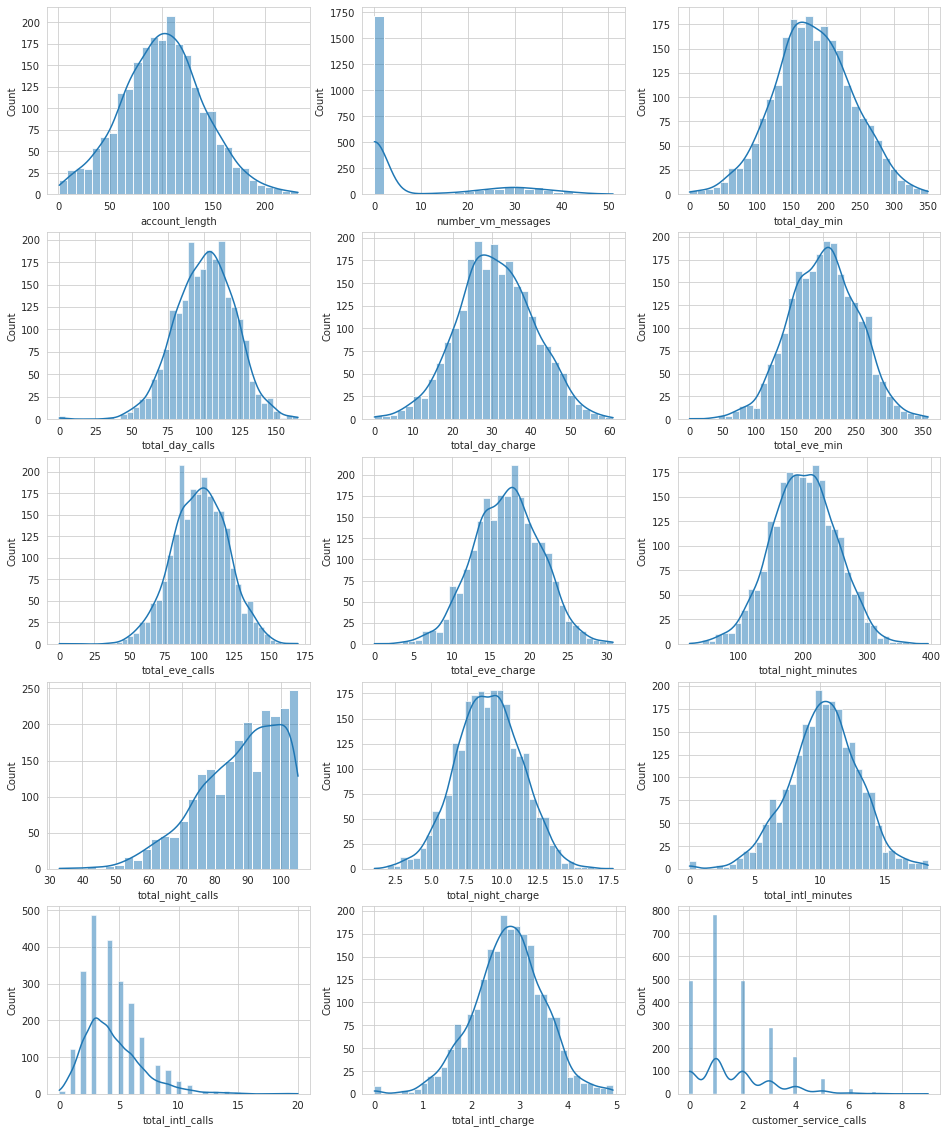

In [7]:
data = train
fig, axes = plt.subplots(5, 3)
fig.set_figwidth(16)
fig.set_figheight(20)
sns.histplot(data=data, x='account_length', kde=True, ax=axes[0,0])
sns.histplot(data=data, x='number_vm_messages', kde=True, ax=axes[0,1])
sns.histplot(data=data, x='total_day_min', kde=True, ax=axes[0,2])
sns.histplot(data=data, x='total_day_calls', kde=True, ax=axes[1,0])
sns.histplot(data=data, x='total_day_charge', kde=True, ax=axes[1,1])
sns.histplot(data=data, x='total_eve_min', kde=True, ax=axes[1,2])
sns.histplot(data=data, x='total_eve_calls', kde=True, ax=axes[2,0])
sns.histplot(data=data, x='total_eve_charge', kde=True, ax=axes[2,1])
sns.histplot(data=data, x='total_night_minutes', kde=True, ax=axes[2,2])
sns.histplot(data=data, x='total_night_calls', kde=True, ax=axes[3,0])
sns.histplot(data=data, x='total_night_charge', kde=True, ax=axes[3,1])
sns.histplot(data=data, x='total_intl_minutes', kde=True, ax=axes[3,2])
sns.histplot(data=data, x='total_intl_calls', kde=True, ax=axes[4,0])
sns.histplot(data=data, x='total_intl_charge', kde=True, ax=axes[4,1])
sns.histplot(data=data, x='customer_service_calls', kde=True, ax=axes[4,2])
plt.show()

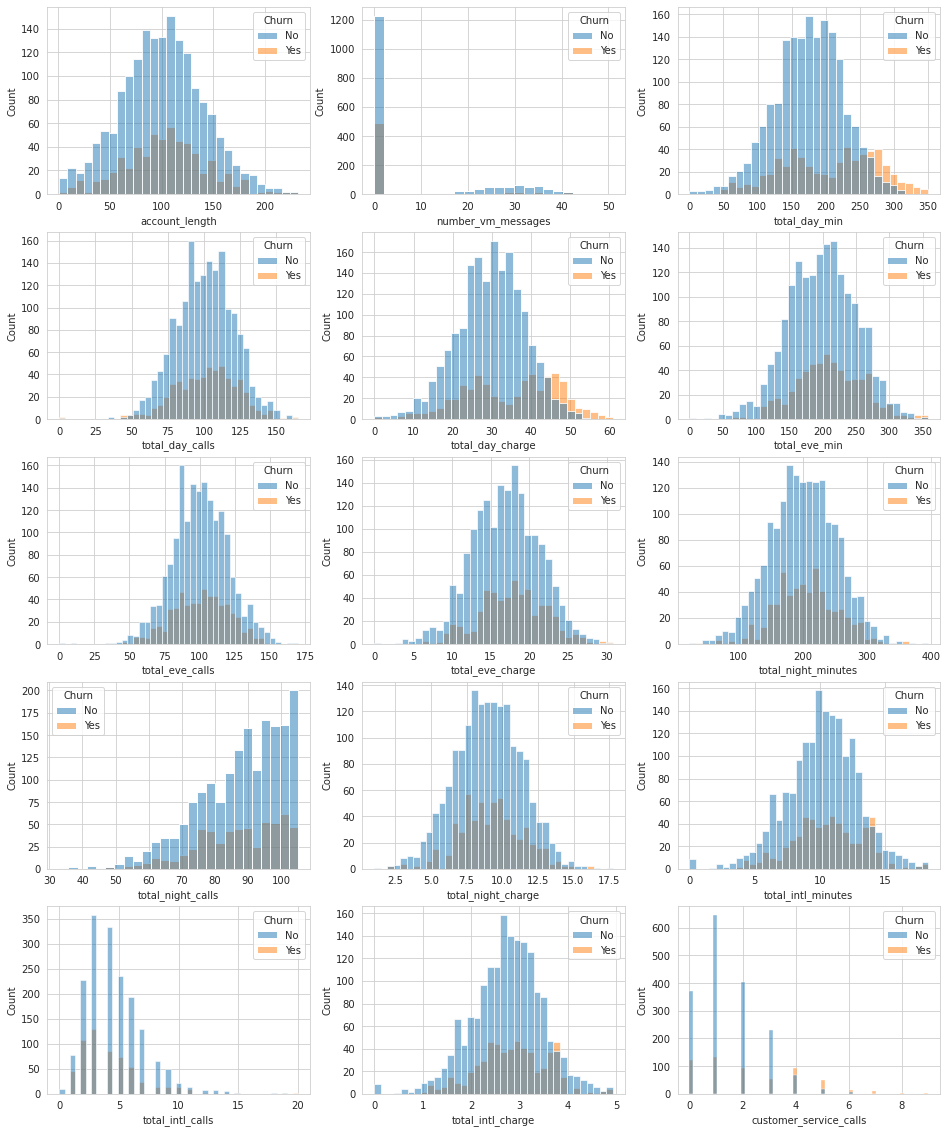

In [93]:
data = train.copy()
fig, axes = plt.subplots(5, 3)
fig.set_figwidth(16)
fig.set_figheight(20)
sns.histplot(data=data, x='account_length', ax=axes[0,0], hue='Churn')
sns.histplot(data=data, x='number_vm_messages', ax=axes[0,1], hue='Churn')
sns.histplot(data=data, x='total_day_min', ax=axes[0,2], hue='Churn')
sns.histplot(data=data, x='total_day_calls', ax=axes[1,0], hue='Churn')
sns.histplot(data=data, x='total_day_charge', ax=axes[1,1], hue='Churn')
sns.histplot(data=data, x='total_eve_min', ax=axes[1,2], hue='Churn')
sns.histplot(data=data, x='total_eve_calls', ax=axes[2,0], hue='Churn')
sns.histplot(data=data, x='total_eve_charge', ax=axes[2,1], hue='Churn')
sns.histplot(data=data, x='total_night_minutes', ax=axes[2,2], hue='Churn')
sns.histplot(data=data, x='total_night_calls', ax=axes[3,0], hue='Churn')
sns.histplot(data=data, x='total_night_charge', ax=axes[3,1], hue='Churn')
sns.histplot(data=data, x='total_intl_minutes', ax=axes[3,2], hue='Churn')
sns.histplot(data=data, x='total_intl_calls', ax=axes[4,0], hue='Churn')
sns.histplot(data=data, x='total_intl_charge', ax=axes[4,1], hue='Churn')
sns.histplot(data=data, x='customer_service_calls', ax=axes[4,2], hue='Churn')
plt.show()

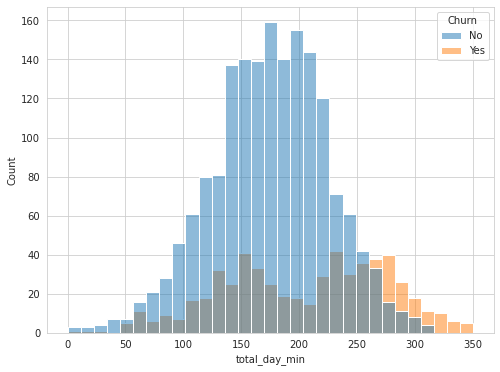

In [95]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train, x='total_day_min', hue='Churn')
plt.savefig('tdmh.jpg', dpi=100)
plt.show()

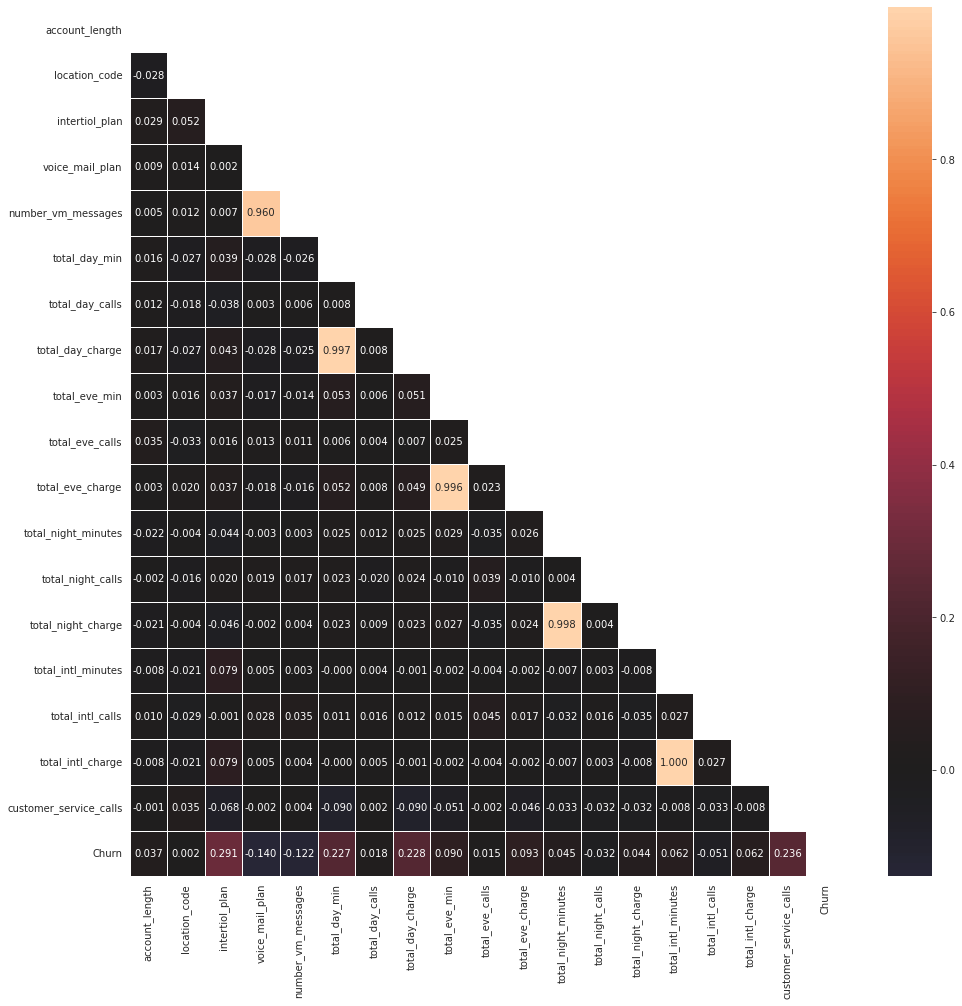

In [9]:
data = train.copy()
data['Churn'] = data['Churn'].str.lower()
for col in ['intertiol_plan', 'voice_mail_plan', 'Churn']:
    data[col] = data[col].map({'yes': 1, 'no': 0})
plt.figure(figsize=(16,16))
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask,  center=0, linewidths=1, annot=True, fmt=".3f")
plt.show()

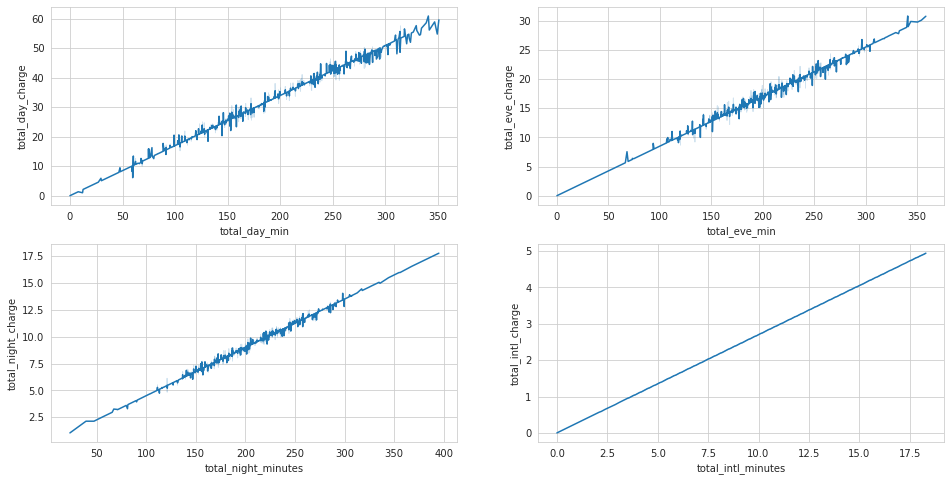

In [10]:
data = train.copy()
fig, axes = plt.subplots(2, 2)
fig.set_figwidth(16)
fig.set_figheight(8)
sns.lineplot(data=data, x='total_day_min', y='total_day_charge', ax=axes[0,0])
sns.lineplot(data=data, x='total_eve_min', y='total_eve_charge', ax=axes[0,1])
sns.lineplot(data=data, x='total_night_minutes', y='total_night_charge', ax=axes[1,0])
sns.lineplot(data=data, x='total_intl_minutes', y='total_intl_charge', ax=axes[1,1])
plt.show()

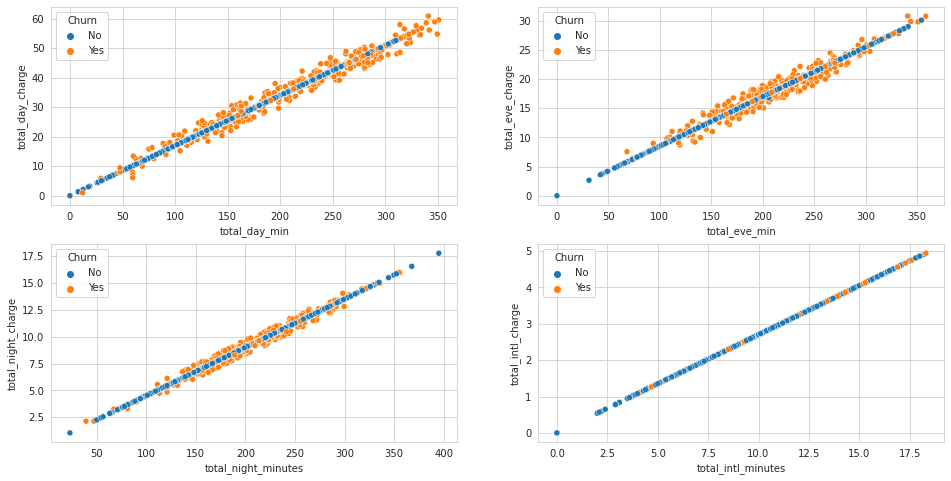

In [88]:
data = train.copy()
fig, axes = plt.subplots(2, 2)
fig.set_figwidth(16)
fig.set_figheight(8)
sns.scatterplot(data=data, x='total_day_min', y='total_day_charge', ax=axes[0,0], hue='Churn')
sns.scatterplot(data=data, x='total_eve_min', y='total_eve_charge', ax=axes[0,1], hue='Churn')
sns.scatterplot(data=data, x='total_night_minutes', y='total_night_charge', ax=axes[1,0], hue='Churn')
sns.scatterplot(data=data, x='total_intl_minutes', y='total_intl_charge', ax=axes[1,1], hue='Churn')
plt.savefig('lr.jpg', dpi=100)
plt.show()

<Figure size 1152x1152 with 0 Axes>

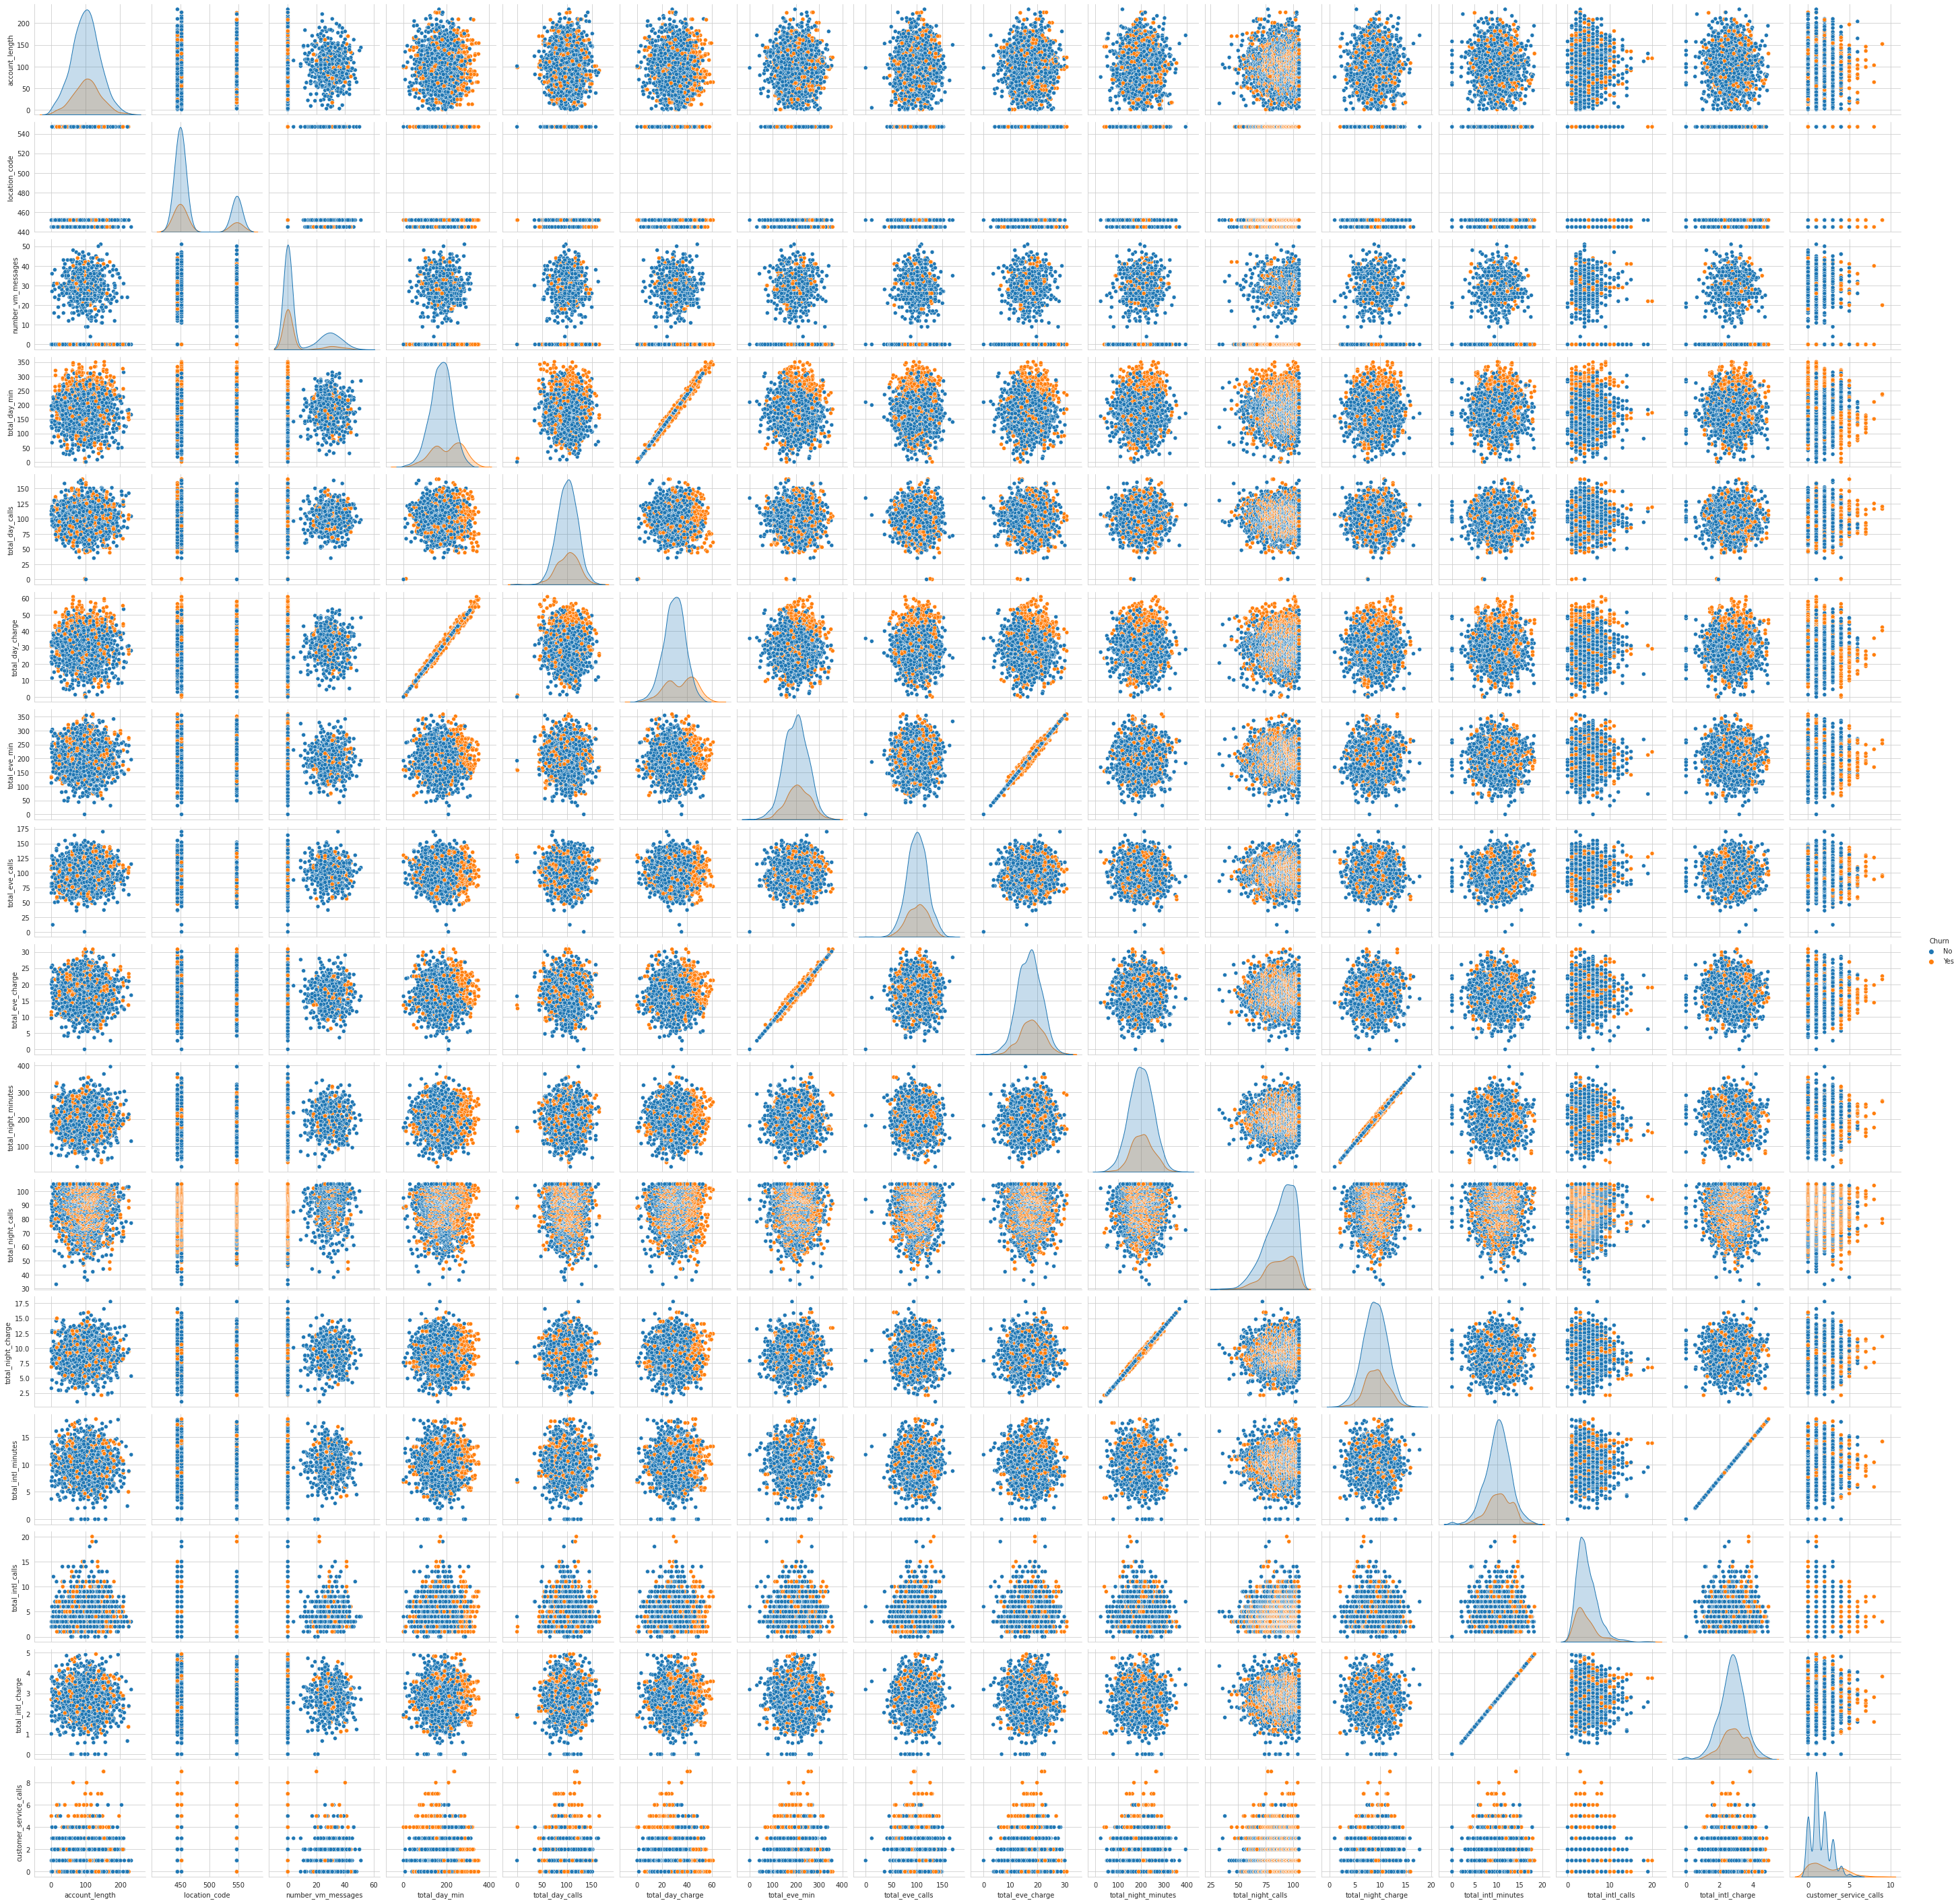

In [12]:
plt.figure(figsize=(16,16))
sns.pairplot(train, hue="Churn")
plt.savefig('tpairplot.jpg', dpi=150)
plt.show()

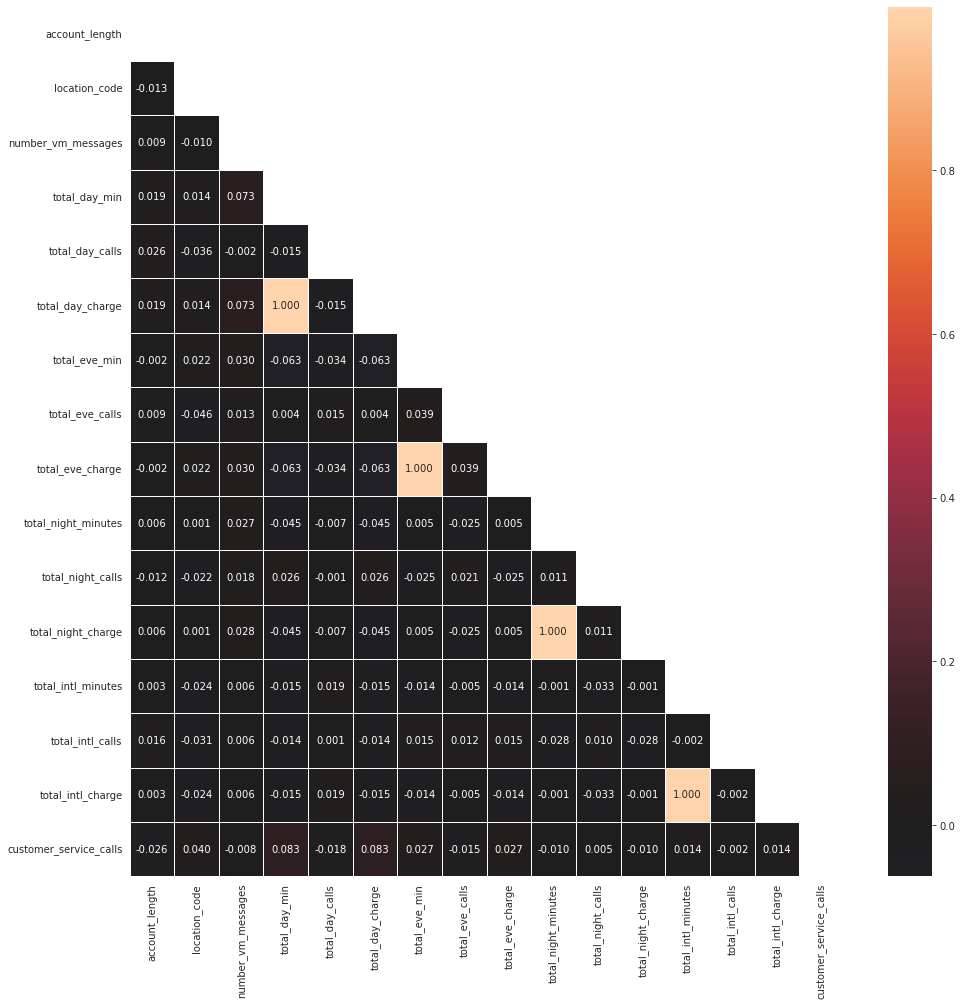

In [13]:
data = train.copy()
data = data.loc[data.Churn == 'No']
plt.figure(figsize=(16,16))
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask,  center=0, linewidths=1, annot=True, fmt=".3f")
plt.show()

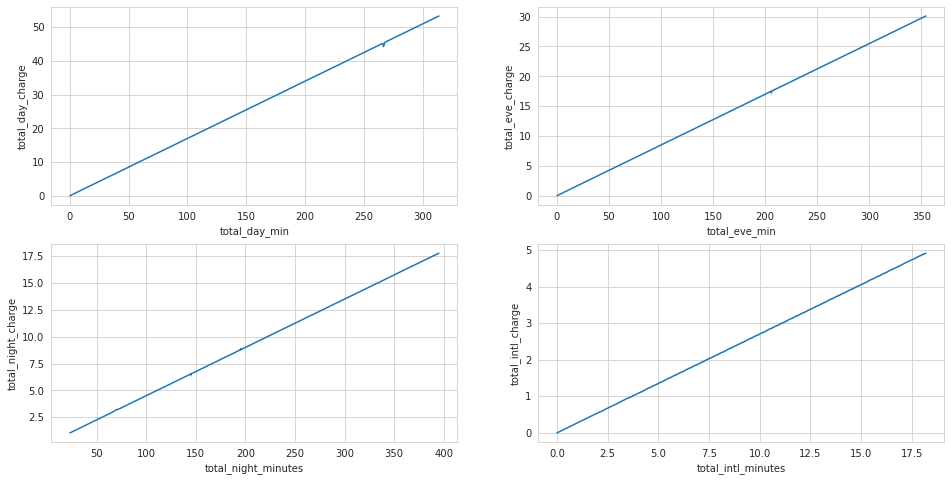

In [14]:
data = train.copy()
data = data.loc[data.Churn == 'No']
fig, axes = plt.subplots(2, 2)
fig.set_figwidth(16)
fig.set_figheight(8)
sns.lineplot(data=data, x='total_day_min', y='total_day_charge', ax=axes[0,0])
sns.lineplot(data=data, x='total_eve_min', y='total_eve_charge', ax=axes[0,1])
sns.lineplot(data=data, x='total_night_minutes', y='total_night_charge', ax=axes[1,0])
sns.lineplot(data=data, x='total_intl_minutes', y='total_intl_charge', ax=axes[1,1])
plt.show()

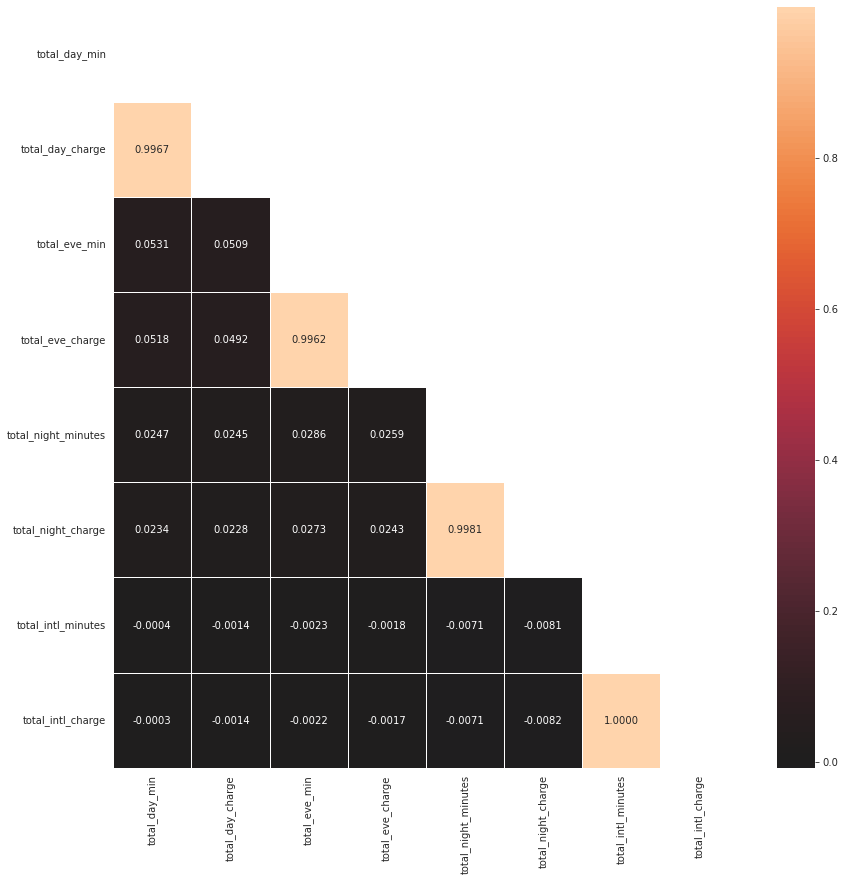

In [86]:
data = train.copy()
min_charge_cols = ['total_day_min', 'total_day_charge', 'total_eve_min', 'total_eve_charge', 'total_night_minutes', 'total_night_charge', 'total_intl_minutes', 'total_intl_charge']
data = data[min_charge_cols]
plt.figure(figsize=(14,14))
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask,  center=0, linewidths=1, annot=True, fmt=".4f")
plt.savefig('corrwc.jpg', dpi=100)
plt.show()

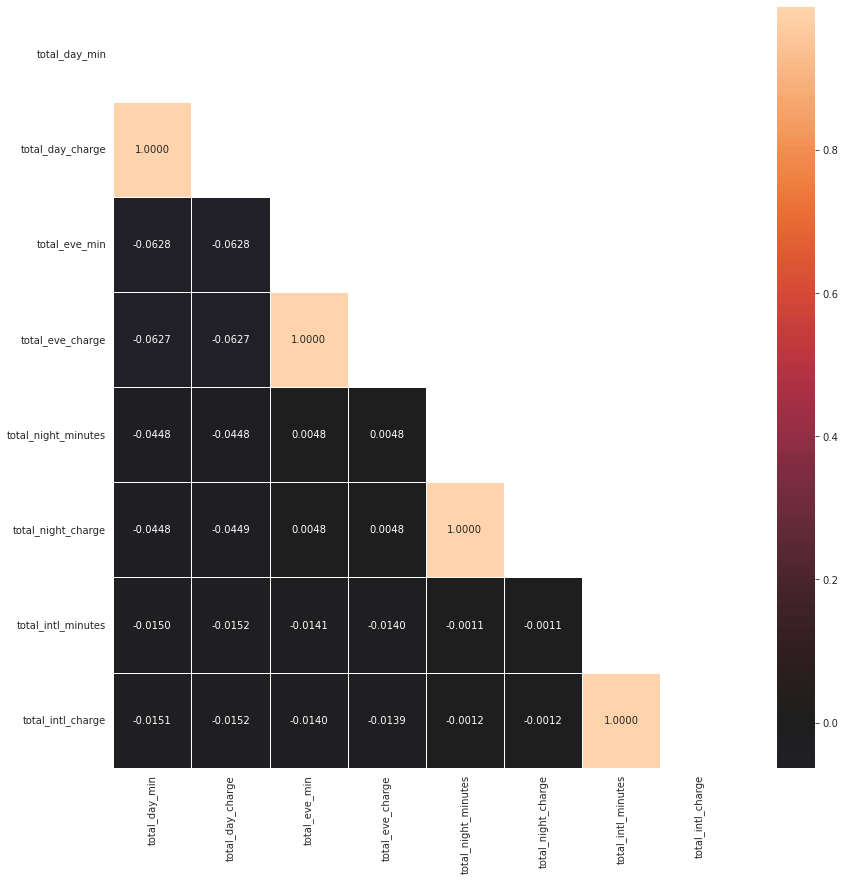

In [87]:
data = train.copy()
data = data.loc[data.Churn == 'No']
data = data[min_charge_cols]
plt.figure(figsize=(14,14))
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask,  center=0, linewidths=1, annot=True, fmt=".4f")
plt.savefig('corrwoc.jpg', dpi=100)
plt.show()

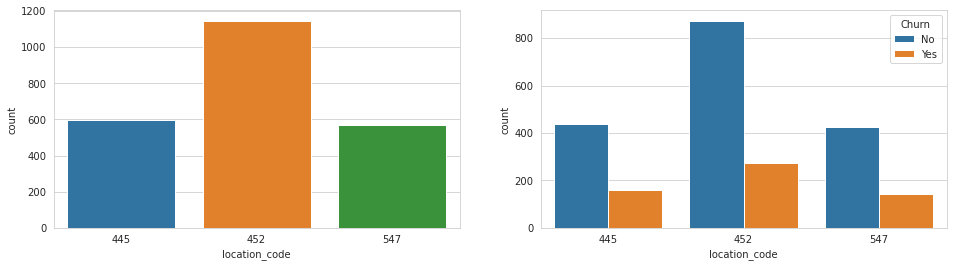

In [17]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(16)
fig.set_figheight(4)
sns.countplot(data=train, x='location_code', ax=axes[0])
sns.countplot(data=train, x='location_code', hue='Churn', ax=axes[1])
plt.show()

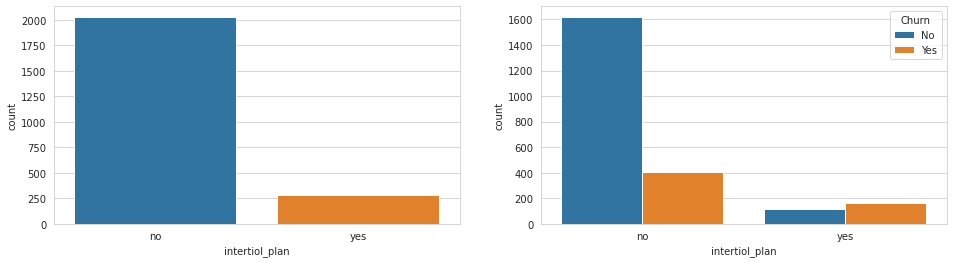

Churn
Yes      165
No       116
dtype: int64

In [89]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(16)
fig.set_figheight(4)
sns.countplot(data=train, x='intertiol_plan', ax=axes[0])
sns.countplot(data=train, x='intertiol_plan', hue='Churn', ax=axes[1])
plt.savefig('ipc.jpg', dpi=100)
plt.show()

train.loc[train.intertiol_plan == 'yes', ['Churn']].value_counts()

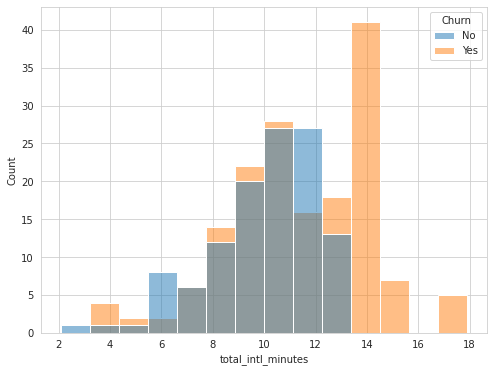

In [90]:
data = train.loc[train.intertiol_plan == 'yes']
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='total_intl_minutes', hue='Churn')
plt.savefig('imh.jpg', dpi=100)
plt.show()

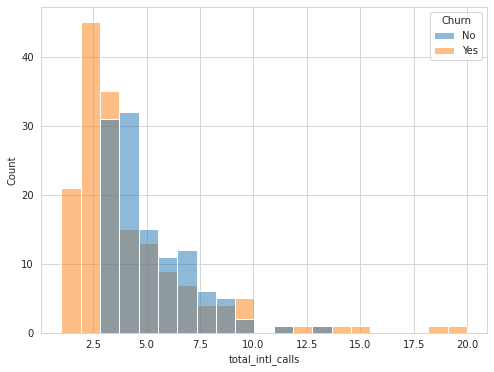

In [91]:
data = train.loc[train.intertiol_plan == 'yes']
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='total_intl_calls', hue='Churn')
plt.savefig('ich.jpg', dpi=100)
plt.show()

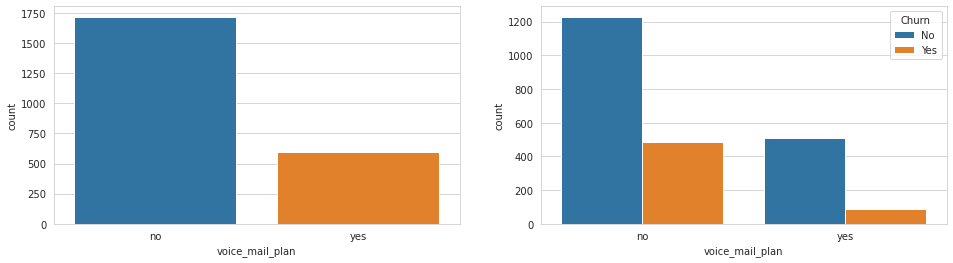

In [21]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(16)
fig.set_figheight(4)
sns.countplot(data=train, x='voice_mail_plan', ax=axes[0])
sns.countplot(data=train, x='voice_mail_plan', hue='Churn', ax=axes[1])
plt.show()

In [22]:
train.loc[train.total_day_min > 300].Churn.value_counts()

Yes    40
No      8
Name: Churn, dtype: int64

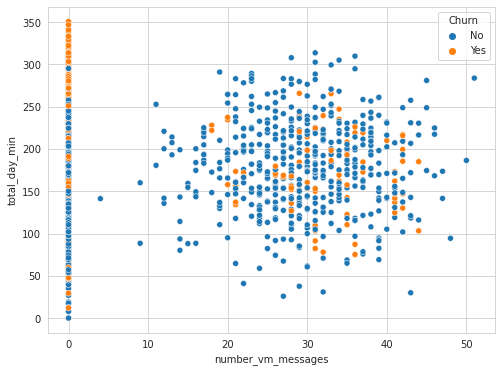

Churn
Yes      40
No        3
dtype: int64

In [96]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train, x='number_vm_messages', y='total_day_min', hue='Churn')
plt.savefig('nvms.jpg', dpi=100)
plt.show()

train.loc[(train.voice_mail_plan == 'no') & (train.total_day_min > 300), ['Churn']].value_counts()

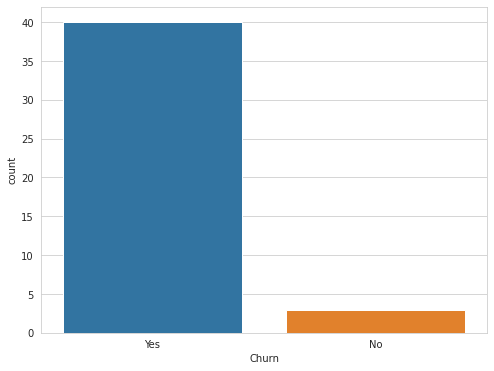

In [24]:
data=train.loc[(train.voice_mail_plan == 'no') & (train.total_day_min > 300)]
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Churn')
plt.show()

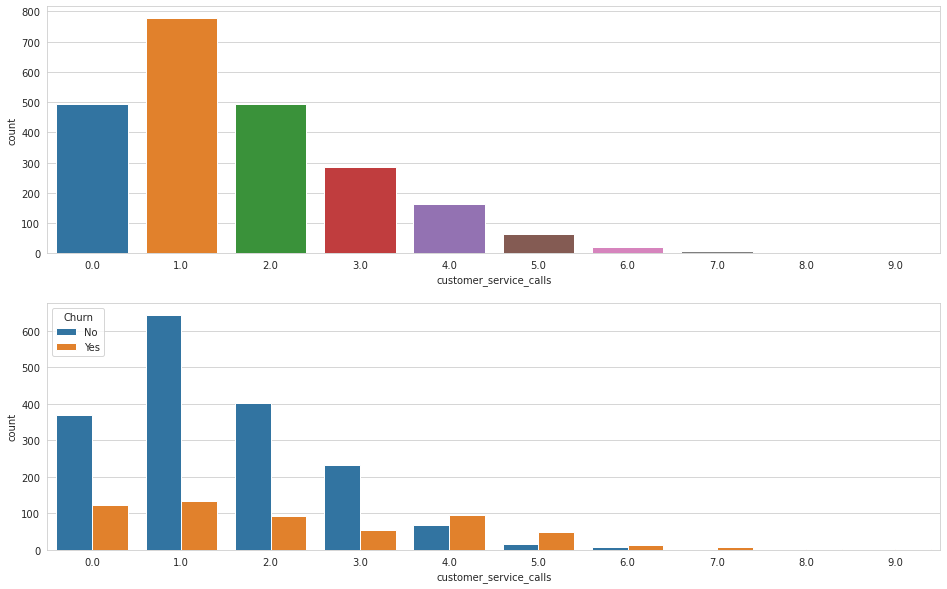

customer_service_calls Churn
customer_id                              
1370                            7.0   Yes
1403                            7.0   Yes
1498                            9.0   Yes
1605                            9.0   Yes
2146                            7.0   Yes
2462                            8.0   Yes
2503                            7.0   Yes
2627                            7.0   Yes
2635                            7.0   Yes
2765                            7.0   Yes
2881                            7.0   Yes
2920                            7.0   Yes
3191                            8.0   Yes

In [84]:
fig, axes = plt.subplots(2, 1)
fig.set_figwidth(16)
fig.set_figheight(10)
sns.countplot(data=train, x='customer_service_calls', ax=axes[0])
sns.countplot(data=train, x='customer_service_calls', hue='Churn', ax=axes[1])
plt.savefig('csc.jpg', dpi=150)
plt.show()

train.loc[train.customer_service_calls > 6, ['customer_service_calls', 'Churn']]

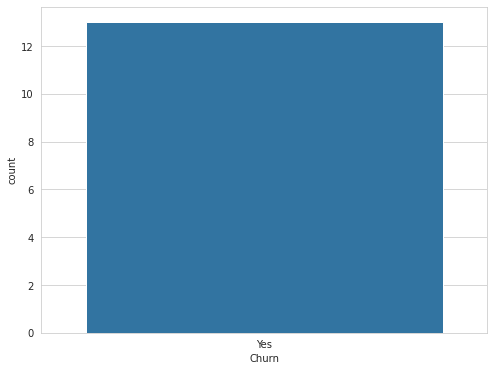

In [85]:
data = train.copy()
data = data.loc[train.customer_service_calls > 6]
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Churn')
plt.show()

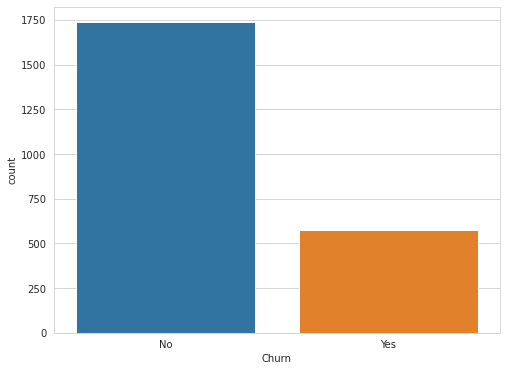

No     1737
Yes     575
Name: Churn, dtype: int64

In [26]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='Churn')
plt.show()

train.Churn.value_counts()

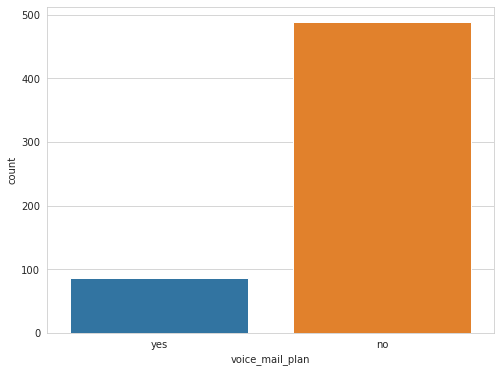

no     488
yes     87
Name: voice_mail_plan, dtype: int64

In [27]:
data = train.copy()
data = data.loc[data.Churn == 'Yes']
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='voice_mail_plan')
plt.show()
data.voice_mail_plan.value_counts()

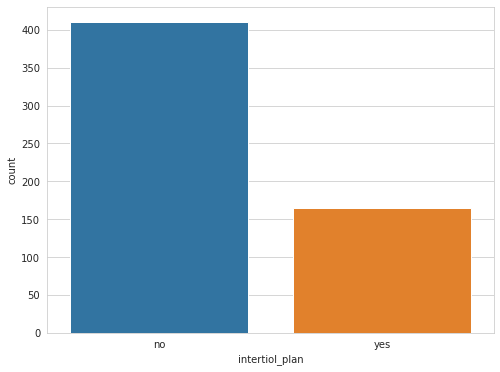

no     410
yes    165
Name: intertiol_plan, dtype: int64

In [28]:
data = train.copy()
data = data.loc[data.Churn == 'Yes']
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='intertiol_plan')
plt.show()
data.intertiol_plan.value_counts()

In [29]:
# data = train.copy()
# data = data.loc[(data.intertiol_plan == 'no') & (data.voice_mail_plan == 'no') & (data.total_intl_minutes > 16)]
# plt.figure(figsize=(8, 6))
# sns.countplot(data=data, x='Churn')
# plt.show()
# data.Churn.value_counts()

In [30]:
train['total_min'] = train['total_day_min'] + train['total_eve_min'] + train['total_night_minutes'] + train['total_intl_minutes']

In [31]:
lr_day = LinearRegression()
lr_eve = LinearRegression()
lr_nyt = LinearRegression()

lr_day.fit(train[['total_day_min']], train['total_day_charge'])
lr_eve.fit(train[['total_eve_min']], train['total_eve_charge'])
lr_nyt.fit(train[['total_night_minutes']], train['total_night_charge'])

LinearRegression()

In [32]:
train['expected_total_day_charge'] = lr_day.predict(train[['total_day_min']])
train['expected_total_eve_charge'] = lr_eve.predict(train[['total_eve_min']])
train['expected_total_nyt_charge'] = lr_nyt.predict(train[['total_night_minutes']])

In [33]:
train['error_total_day_charge'] = abs(train['expected_total_day_charge'] - train['total_day_charge'])
train['error_total_eve_charge'] = abs(train['expected_total_eve_charge'] - train['total_eve_charge'])
train['error_total_nyt_charge'] = abs(train['expected_total_nyt_charge'] - train['total_night_charge'])

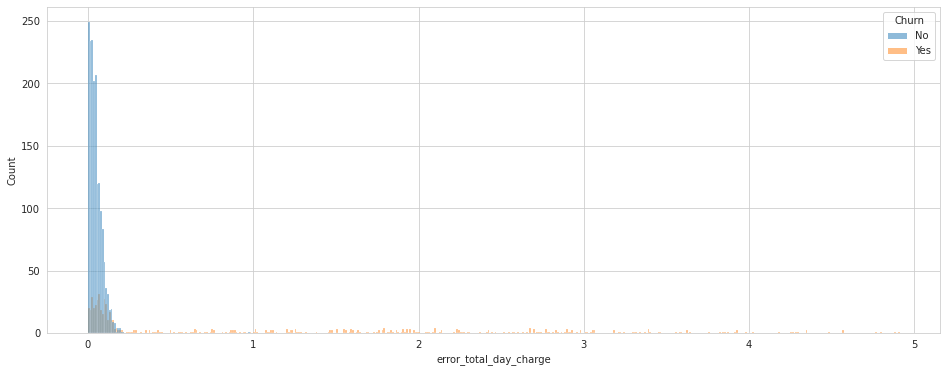

In [34]:
plt.figure(figsize=(16, 6))
sns.histplot(data=train, x='error_total_day_charge', hue='Churn')
plt.show()

In [35]:
train.loc[train.Churn == 'Yes', ['error_total_day_charge']].describe().T

count      mean       std       min       25%  \
error_total_day_charge  575.0  0.976184  1.243208  0.000178  0.066556   

                             50%      75%       max  
error_total_day_charge  0.148464  1.78997  4.909939

In [36]:
train.loc[train.Churn == 'No', ['error_total_day_charge']].describe().T

count      mean       std      min       25%    50%  \
error_total_day_charge  1737.0  0.047731  0.042806  0.00006  0.019175  0.039   

                             75%       max  
error_total_day_charge  0.067352  0.977829

In [37]:
train['expected_day_churn'] = 0
train.loc[train.error_total_day_charge > 0.067352, 'expected_day_churn'] = 1

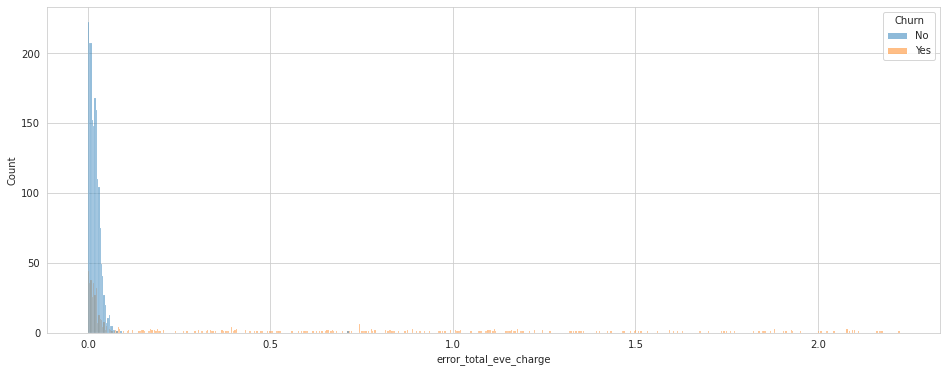

In [38]:
plt.figure(figsize=(16, 6))
sns.histplot(data=train, x='error_total_eve_charge', hue='Churn')
plt.show()

In [39]:
train.loc[train.Churn == 'Yes', ['error_total_eve_charge']].describe().T

count      mean       std       min      25%  \
error_total_eve_charge  575.0  0.442958  0.608917  0.000015  0.01421   

                             50%       75%      max  
error_total_eve_charge  0.043058  0.778438  2.22328

In [40]:
train.loc[train.Churn == 'No', ['error_total_eve_charge']].describe().T

count      mean      std       min       25%  \
error_total_eve_charge  1737.0  0.018588  0.02152  0.000015  0.007236   

                             50%       75%      max  
error_total_eve_charge  0.016194  0.025837  0.71124

In [41]:
train['expected_eve_churn'] = 0
train.loc[train.error_total_eve_charge > 0.025837, 'expected_eve_churn'] = 1

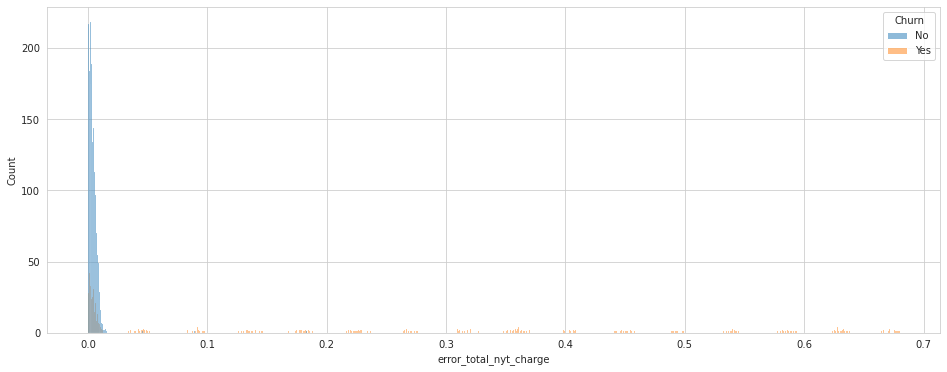

In [42]:
plt.figure(figsize=(16, 6))
sns.histplot(data=train, x='error_total_nyt_charge', hue='Churn')
plt.show()

In [43]:
train.loc[train.Churn == 'Yes', ['error_total_nyt_charge']].describe().T

count      mean       std       min       25%  \
error_total_nyt_charge  575.0  0.169443  0.222026  0.000049  0.003119   

                             50%       75%       max  
error_total_nyt_charge  0.009232  0.337558  0.679915

In [44]:
train.loc[train.Churn == 'No', ['error_total_nyt_charge']].describe().T

count      mean       std       min       25%  \
error_total_nyt_charge  1737.0  0.003981  0.005595  0.000007  0.001631   

                             50%       75%       max  
error_total_nyt_charge  0.003319  0.005493  0.182717

In [45]:
train['expected_nyt_churn'] = 0
train.loc[train.error_total_nyt_charge > 0.005493, 'expected_nyt_churn'] = 1

In [75]:
encoded_train = pd.get_dummies(train, columns=['location_code'])
#encoded_train = train.copy()
encoded_train['Churn'] = encoded_train['Churn'].str.lower()
for col in ['intertiol_plan', 'voice_mail_plan', 'Churn']:
    encoded_train[col] = encoded_train[col].map({'yes': 1, 'no': 0})
encoded_train.tail()

account_length  intertiol_plan  voice_mail_plan  \
customer_id                                                    
3317                  109.0               0                0   
3318                  185.0               1                1   
3319                   55.0               1                0   
3320                  138.0               1                0   
3321                   24.0               0                0   

             number_vm_messages  total_day_min  total_day_calls  \
customer_id                                                       
3317                        0.0          180.0            100.0   
3318                       30.0          154.1            114.0   
3319                        0.0          188.9             88.0   
3320                        0.0          191.2            130.0   
3321                        0.0          251.0             95.0   

             total_day_charge  total_eve_min  total_eve_calls  \
customer_id                                                     
3317                    30.60          229.0            103.0   
3318                    26.20          118.7            106.0   
3319                    34.62          270.1            105.0   
3320                    32.35          164.5             88.0   
3321                    40.31          179.9             77.0   

             total_eve_charge  ...  expected_total_nyt_charge  \
customer_id                    ...                              
3317                    19.47  ...                   6.275572   
3318                    10.09  ...                  11.622905   
3319                    22.77  ...                   9.434542   
3320                    14.00  ...                  10.859000   
3321                    16.63  ...                   8.517857   

             error_total_day_charge  error_total_eve_charge  \
customer_id                                                   
3317                       0.000825                0.009924   
3318                       0.028294                0.040723   
3319                       2.516645                0.166380   
3320                       0.141649                0.004561   
3321                       2.277298                1.322882   

             error_total_nyt_charge  expected_day_churn  expected_eve_churn  \
customer_id                                                                   
3317                       0.005572                   0                   0   
3318                       0.007095                   0                   1   
3319                       0.264542                   1                   1   
3320                       0.399000                   1                   0   
3321                       0.227857                   1                   1   

             expected_nyt_churn  location_code_445  location_code_452  \
customer_id                                                             
3317                          1                  0                  1   
3318                          1                  0                  1   
3319                          1                  0                  1   
3320                          1                  0                  0   
3321                          1                  0                  0   

             location_code_547  
customer_id                     
3317                         0  
3318                         0  
3319                         0  
3320                         1  
3321                         1  

[5 rows x 31 columns]

In [76]:
# plt.figure(figsize=(16,16))
# sns.pairplot(encoded_train, hue="Churn")
# plt.savefig('etpairplot.jpg', dpi=150)
# plt.show()

In [77]:
X = encoded_train.drop(columns=['Churn'])
y = encoded_train.Churn

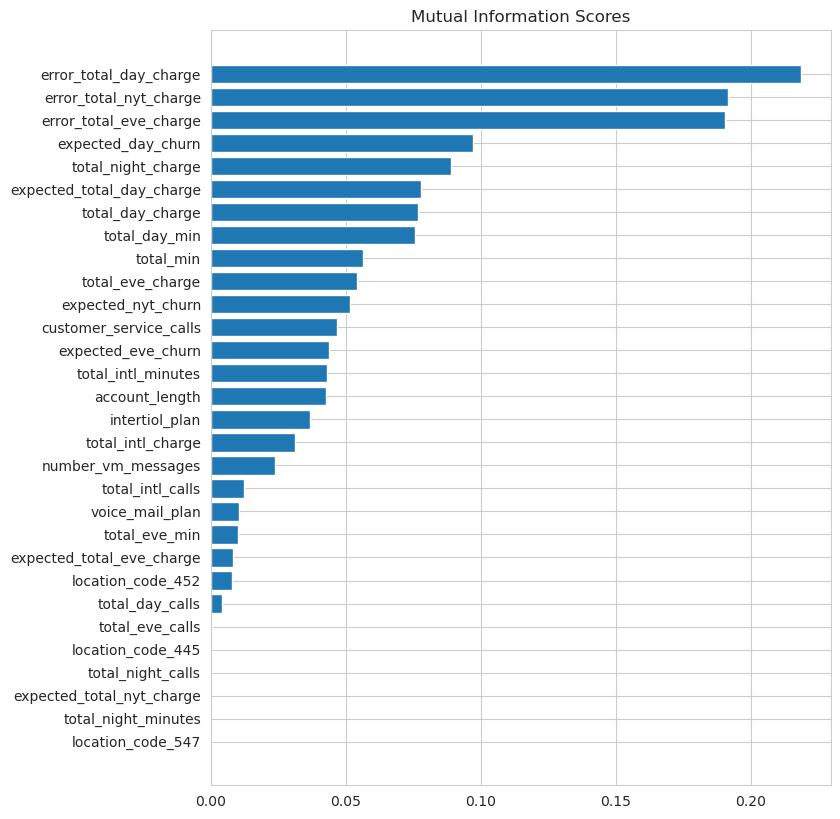

In [78]:
plot_mi_scores(make_mi_scores(X, y))

In [79]:
evaluate_for_models(models, X, y)

Model  ScoreMean  Score Standard Deviation
4           XGBClassifier   0.927979                  0.015098
3  RandomForestClassifier   0.893450                  0.015544
0  DecisionTreeClassifier   0.865545                  0.024047
2              GaussianNB   0.690587                  0.027498
1    KNeighborsClassifier   0.496880                  0.026872

In [80]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

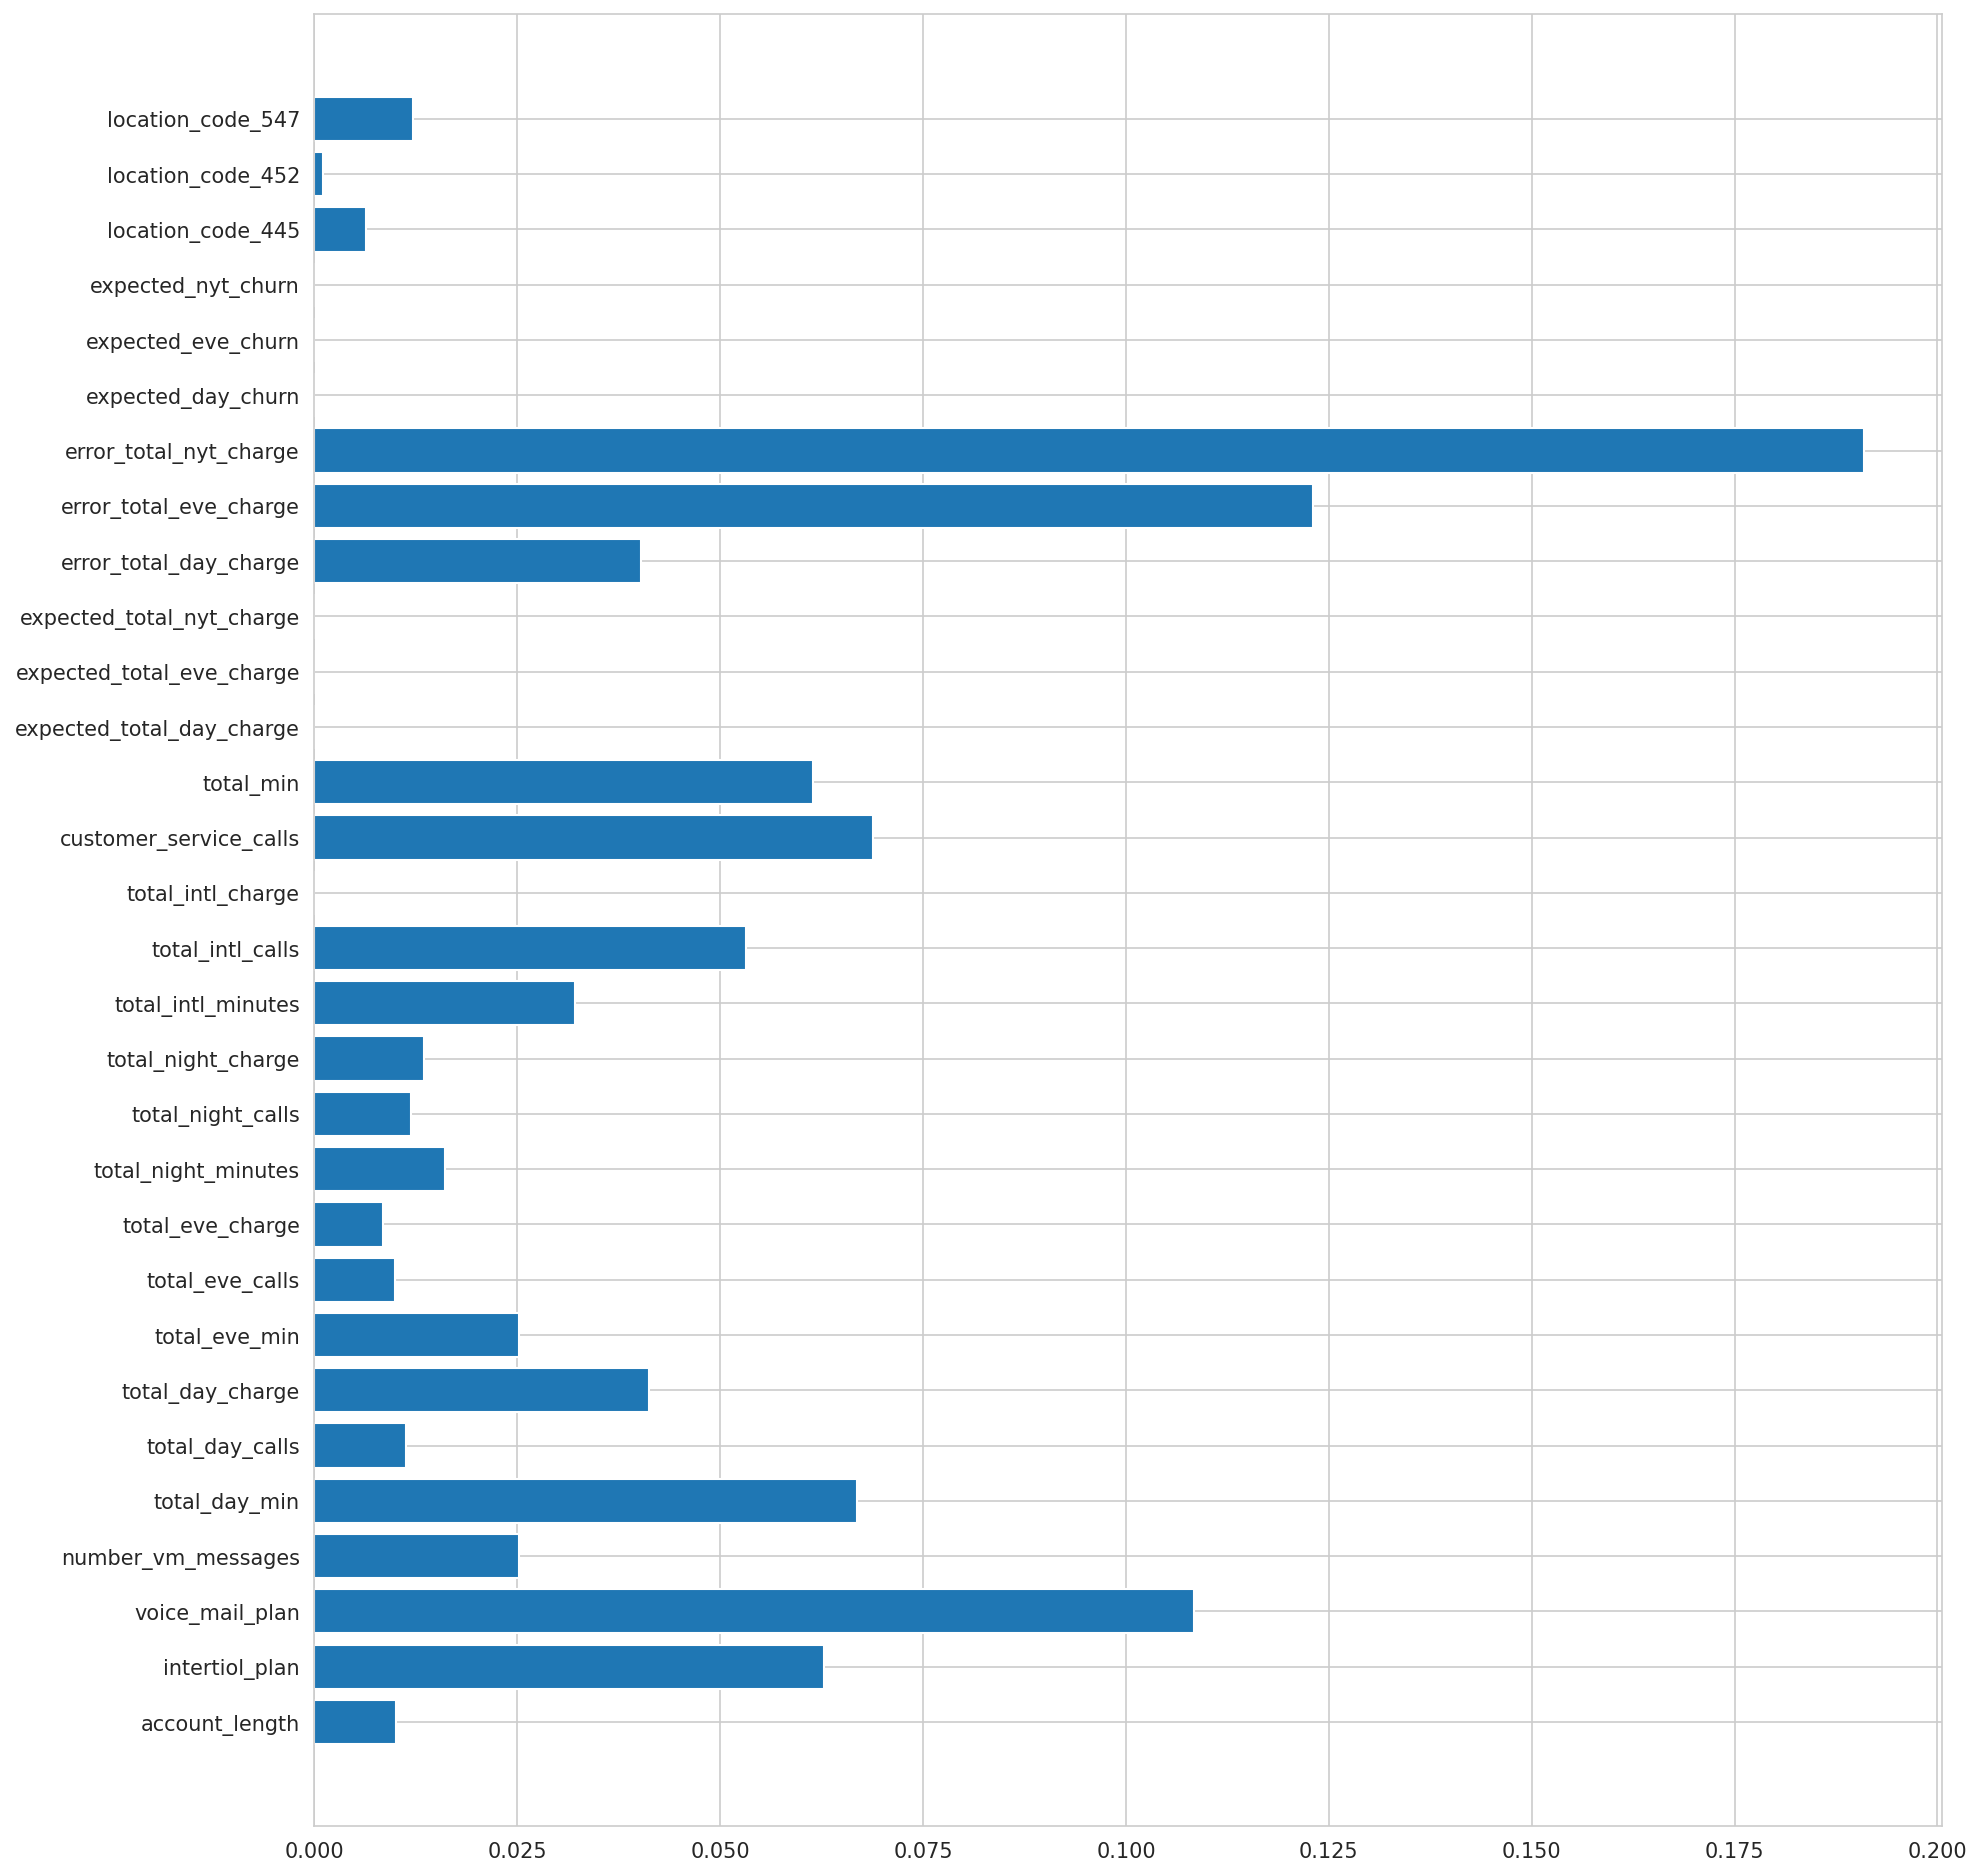

In [81]:
plt.figure(dpi=150, figsize=(14, 16))
plt.barh(X.columns, xgb.feature_importances_)
plt.show()

In [82]:
# estimator = rf.estimators_[5]

# export_graphviz(estimator, out_file='rftree.dot', 
#                 feature_names = X.columns,
#                 class_names = 'Churn',
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

In [83]:
# plot_tree(xgb)
# plt.show()